# <b> The second part of the assignment project</b>
In this part I'll use the dataset I have made to build a CNN.<br>
The dataset consists of <b>three major parts:</b><br> 
• <i> training_data.npy </i> - dataset from curated files of 10 most common labels. Each label (except the last one) has 75 objects and from each file I made 7 segments so the entire dataset has ~75*7*10=5250 mel-spectograms<br>
• <i> traning_data(noisy).npy </i> - dataset from noisy files of the same 10 labels. Each label has 50 objects and I made 12 segments. Because noisy files had longer durations and in order to have same segment's length(3 sec) I had to divide files into more segments. So final size is 50*12*10=6000 <br>
• <i> traning_data(noisy)(test).npy </i> - test dataset from noisy files for calculating final results. Size ~25*12*10=3000<br><br>
First I tried to train the network with only curated files and evaluate it on curated data as well. This approach gave something about 80% acc on test set. But only 15% on noisy data. So I understand that this approach will not work anyway better.<br>
Then I decided to mix curated and noisy data and train model on that dataset.
<b>The results are below:</b>

## Preprocessing

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms
from torchsummary import summary
from tqdm.notebook import tqdm
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
def calculating_loss(net, X, y, batch_size, loss_fn, optimizer, train_model=False):
  """
  Calculating loss for given parameters.
  Has option to train model(if train_model=True)
  """
  X, y = shuffle(X, y)

  for k in range(0, len(y), BATCH_SIZE):
    X_batch = X[k:k+BATCH_SIZE].to(device)
    y_batch = y[k:k+BATCH_SIZE].to(device)
    
    if train_model:
      net.train()
      net.zero_grad()
      outputs = net(X_batch.view(-1, 1, 96, 130))
      loss = loss_fn(outputs, y_batch)
      loss.backward()
      optimizer.step()    
    else:
      net.eval()
      with torch.no_grad():
        outputs = net(X_batch.view(-1, 1, 96, 130))
        loss = loss_fn(outputs, y_batch)

  loss = float(loss)
  loss = np.round(loss, 2)

  return loss

def calculating_acc(net, X, y):
  """ Calculating accuracy for given network and data """
  correct = 0
  total = 0

  net.eval()
  with torch.no_grad():
    for i in range(len(y)):
      label = int(y[i])
      X_inner = X[i].to(device)
      output = net(X_inner.view(1, 1, 96, 130))
      pred = int(torch.argmax(output))
      
      if pred==label:
        correct += 1

      total += 1

  acc = correct / total * 100
  acc = np.round(acc, 2)

  return acc

def plot_results(train_loss_array, test_loss_array, train_acc_array, test_acc_array, EPOCHS):
  """Plots loss and accuracy for train and test datasets"""
  plt.figure(figsize=(20, 5))

  plt.subplot(1, 2, 1)
  sns.lineplot(x=EPOCHS, y=train_loss_array, color='purple', linewidth=2, label='Train loss')
  sns.lineplot(x=EPOCHS, y=test_loss_array, color='deepskyblue', linewidth=2, label='Test loss')
  plt.xticks(np.arange(0, len(train_loss_array), 5))
  plt.legend()
  plt.title('Train  and Test loss per epoch', fontsize=15)

  plt.subplot(1, 2, 2)
  sns.lineplot(x=EPOCHS, y=train_acc_array, color='purple', linewidth=2, label='Train acc')
  sns.lineplot(x=EPOCHS, y=test_acc_array, color='deepskyblue', linewidth=2, label='Test acc')
  plt.xticks(np.arange(0, len(train_acc_array), 5))
  plt.legend()
  plt.title('Train and Test acc per epoch', fontsize=15)

  plt.show()

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [4]:
from google.colab import drive
drive.mount("/content/drive")

training_data = np.load('/content/drive/My Drive/Notebooks/Deep/Assignment/training_data.npy', allow_pickle=True)
training_data_noisy = np.load('/content/drive/My Drive/Notebooks/Deep/Assignment/training_data(noisy).npy', allow_pickle=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
print('Curated dataset shape: ', training_data.shape)
print('Noisy dataset shape: ', training_data_noisy.shape)

Curated dataset shape:  (5243, 2)
Noisy dataset shape:  (6000, 2)


In [6]:
np.random.shuffle(training_data)
np.random.shuffle(training_data_noisy)

In [7]:
X1 = np.array([i[0] for i in training_data[:4000]], dtype=np.float32)
X2 = np.array([i[0] for i in training_data_noisy], dtype=np.float32)
X = np.concatenate((X1, X2))
del X1, X2

y1 = np.array([i[1] for i in training_data[:4000]])
y2 = np.array([i[1] for i in training_data_noisy])
y = np.concatenate((y1, y2))
del y1, y2

X, y = shuffle(X, y)

# Curated test data for future 
X_test_curated = np.array([i[0] for i in training_data[4000:]], dtype=np.float32)
y_test_curated = np.array([i[1] for i in training_data[4000:]])

In [8]:
# to range [0, 1] 
X = X / -80

In [9]:
X_train = torch.tensor(X[:9000]).view(-1, 1, 96, 130)
y_train = torch.tensor(y[:9000])

X_test = torch.tensor(X[9000:]).view(-1, 1, 96, 130)
y_test = torch.tensor(y[9000:])

X_test_curated = torch.tensor(X_test_curated).view(-1, 1, 96, 130)
y_test_curated = torch.tensor(y_test_curated)

In [10]:
MEAN= X_train.mean()
STD = X_train.std()
preprocess = transforms.Normalize(mean=MEAN, std=STD)

In [11]:
# Normalizing
X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [12]:
print('Train data shape: ', X_train.size())
print('Test data shape: ', X_test.size())

Train data shape:  torch.Size([9000, 1, 96, 130])
Test data shape:  torch.Size([1000, 1, 96, 130])


## Network architecture

In [13]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # layer 1
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=2)
    self.bn1 = nn.BatchNorm2d(32)
    # Max pool
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    # Layer 2
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.bn2 = nn.BatchNorm2d(64)
    # Layer3
    self.conv3 = nn.Conv2d(64, 128, 3, 1)
    self.bn3 = nn.BatchNorm2d(128)
    # Layer 4
    self.conv4 = nn.Conv2d(128, 128, 3, 1, padding=1)
    self.bn4 = nn.BatchNorm2d(128)
    # Max pool
    self.maxpool2 = nn.MaxPool2d(2, 2)

    self._to_linear = None
    x = torch.randn(96, 130).view(-1, 1, 96, 130)
    x = self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 1024)
    self.dropout1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(1024, 1024)
    self.dropout2 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(1024, 10)

  def convs(self, x):
    x = self.bn1(F.relu(self.conv1(x)))
    x = self.maxpool1(x)
    x = self.bn2(F.relu(self.conv2(x)))
    x = self.bn3(F.relu(self.conv3(x)))
    x = self.bn4(F.relu(self.conv4(x)))
    x = self.maxpool2(x)

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]

    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = self.fc3(x)

    return F.log_softmax(x, dim=1) 

net = Net().to(device)

In [14]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_normal_(m.weight)

net.apply(init_weights)  

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14976, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=

In [15]:
print('Network summary:')
summary(net, input_size=(1, 96, 130))

Network summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 63]             832
       BatchNorm2d-2           [-1, 32, 46, 63]              64
         MaxPool2d-3           [-1, 32, 23, 31]               0
            Conv2d-4           [-1, 64, 21, 29]          18,496
       BatchNorm2d-5           [-1, 64, 21, 29]             128
            Conv2d-6          [-1, 128, 19, 27]          73,856
       BatchNorm2d-7          [-1, 128, 19, 27]             256
            Conv2d-8          [-1, 128, 19, 27]         147,584
       BatchNorm2d-9          [-1, 128, 19, 27]             256
        MaxPool2d-10           [-1, 128, 9, 13]               0
           Linear-11                 [-1, 1024]      15,336,448
          Dropout-12                 [-1, 1024]               0
           Linear-13                 [-1, 1024]       1,049,600
          Dropout-14  

## Training model

In [16]:
EPOCHS = np.arange(11)
BATCH_SIZE = 64
LR = 0.001
WD = 0.003
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr =LR, weight_decay=WD)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

train_loss_array = []
test_loss_array = []
train_acc_array = []
test_acc_array = []

for epoch in tqdm(EPOCHS):
  # Training model and calculating train loss
  train_loss = calculating_loss(net, X_train, y_train, BATCH_SIZE, loss_fn, optimizer, train_model=True)
  train_loss_array.append(train_loss)
  
  # Calculating test loss
  test_loss = calculating_loss(net, X_test, y_test, BATCH_SIZE, loss_fn, optimizer, train_model=False)
  test_loss_array.append(test_loss)

  # Calcualting train and test accuracies
  train_acc = calculating_acc(net, X_train, y_train)
  train_acc_array.append(train_acc)

  test_acc = calculating_acc(net, X_test, y_test)
  test_acc_array.append(test_acc)
  scheduler.step()

In [17]:
r = np.random.randint(0, len(y_test), size=5)
for k in r:
  output = net(X_test[k].view(1, 1, 96, 130).to(device))
  print('gt: ', int(y_test[k]))
  print(output[0])
  print('Pred: ', int(torch.argmax(output)))
  print('---------------------')

gt:  1
tensor([-5.3540, -0.1627, -7.8148, -9.0552, -2.5150, -7.7899, -4.3898, -3.1506,
        -5.3690, -5.5971], device='cuda:0', grad_fn=<SelectBackward>)
Pred:  1
---------------------
gt:  4
tensor([-8.7590, -5.4300, -8.0375, -1.5190, -0.3296, -4.3392, -4.6850, -8.0684,
        -4.5956, -3.7177], device='cuda:0', grad_fn=<SelectBackward>)
Pred:  4
---------------------
gt:  6
tensor([ -5.2285,  -6.8559,  -8.6341,  -8.9170,  -8.7947,  -6.9411,  -0.0137,
         -5.8503, -10.8709,  -5.8553], device='cuda:0',
       grad_fn=<SelectBackward>)
Pred:  6
---------------------
gt:  4
tensor([-11.4715,  -8.4205, -10.8671,  -1.6794,  -0.2196,  -5.2622,  -5.7420,
        -10.9567,  -8.1791,  -6.3345], device='cuda:0',
       grad_fn=<SelectBackward>)
Pred:  4
---------------------
gt:  9
tensor([ -3.2927,  -2.1899,  -5.7749,  -9.0796,  -3.8768, -10.6536,  -6.1159,
         -2.3941,  -3.3284,  -0.3600], device='cuda:0',
       grad_fn=<SelectBackward>)
Pred:  9
---------------------


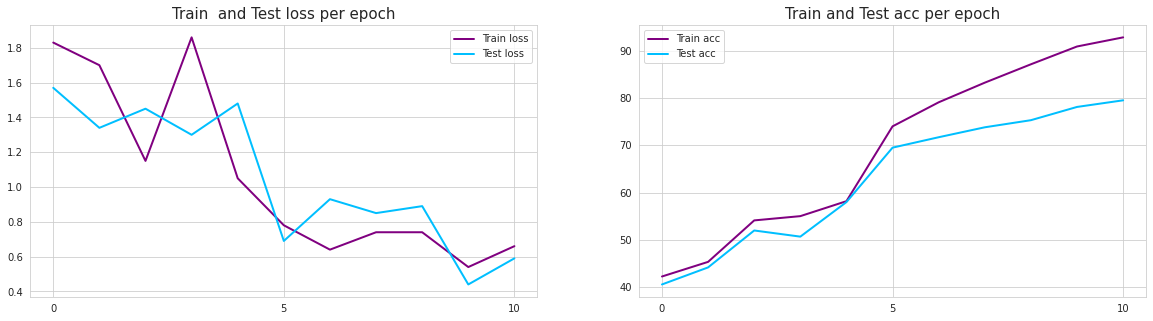

In [18]:
plot_results(train_loss_array, test_loss_array, train_acc_array, test_acc_array, EPOCHS)

*After 10-th epoch model starts overfit badly, so I trained it only for 10 epochs

In [19]:
print('Numerical results:')
print('Train loss: ', train_loss_array)
print('Test loss: ', test_loss_array)
print('--------------'*5)
print('Train acc: ', train_acc_array)
print('Test acc: ', test_acc_array)

Numerical results:
Train loss:  [1.83, 1.7, 1.15, 1.86, 1.05, 0.78, 0.64, 0.74, 0.74, 0.54, 0.66]
Test loss:  [1.57, 1.34, 1.45, 1.3, 1.48, 0.69, 0.93, 0.85, 0.89, 0.44, 0.59]
----------------------------------------------------------------------
Train acc:  [42.28, 45.37, 54.13, 55.03, 58.19, 74.0, 79.08, 83.23, 87.11, 90.87, 92.8]
Test acc:  [40.6, 44.2, 52.0, 50.7, 58.0, 69.5, 71.7, 73.8, 75.3, 78.1, 79.5]


## Additional curated and noisy data

In [20]:
test_data_noisy = np.load('/content/drive/My Drive/Notebooks/Deep/Assignment/training_data(noisy)(test).npy', allow_pickle=True)

In [21]:
X_test_noisy = torch.tensor([i[0] for i in test_data_noisy]).view(-1, 1, 96, 130)
y_test_noisy = torch.tensor([i[1] for i in test_data_noisy])

In [22]:
X_test_noisy = X_test_noisy / -80
X_test_curated = X_test_curated / -80

X_test_noisy = preprocess(X_test_noisy)
X_test_curated = preprocess(X_test_curated)

In [23]:
print('Curated data shape: ', X_test_curated.size())
print('Noisy data shape: ', X_test_noisy.size())

Curated data shape:  torch.Size([1243, 1, 96, 130])
Noisy data shape:  torch.Size([2976, 1, 96, 130])


In [24]:
noisy_acc = calculating_acc(net, X_test_noisy, y_test_noisy)
curated_acc =calculating_acc(net, X_test_curated, y_test_curated)

print('Final results:')
print(f'Accuracy of noisy data: {noisy_acc}%')
print(f'Accuracy of curated data: {curated_acc}%')

Final results:
Accuracy of noisy data: 45.53%
Accuracy of curated data: 88.25%


## <b>Summary</b>

Despite the fact that this model has some problems with noisy data, with clean data it can predict label pretty well. Hence better preprocessing will help this network a lot(more than average).<br>
About the normalization of mel-spectrograms: I tested this architecture on both normalized and not normalized data. Normalized data showed better results so this is just empirical decision.<br>
This is quite everything that I wanted to show for this project. I had an idea to implement attention on spectograms, but as you can see I didn't succeed ((
<br><br>
<b>I’m eager to receive your feedback and further information about the next stages of your selection process.</b>